<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/7_momentum_megafactor_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Momentum Megafactor Simulation

Load libraries and set chart options

In [1]:
if(!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, here, glue)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = TRUE)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


here installed



utf8         (1.2.1 -> 1.2.2 ) [CRAN]
pillar       (1.6.1 -> 1.6.2 ) [CRAN]
tibble       (3.1.2 -> 3.1.3 ) [CRAN]
cli          (3.0.0 -> 3.0.1 ) [CRAN]
iterators    (NA    -> 1.0.13) [CRAN]
zoo          (NA    -> 1.8-9 ) [CRAN]
bit          (NA    -> 4.0.4 ) [CRAN]
tzdb         (NA    -> 0.1.2 ) [CRAN]
bit64        (NA    -> 4.0.5 ) [CRAN]
R.methodsS3  (NA    -> 1.8.1 ) [CRAN]
openssl      (1.4.3 -> 1.4.4 ) [CRAN]
foreach      (NA    -> 1.5.1 ) [CRAN]
xts          (NA    -> 0.12.1) [CRAN]
stringi      (1.7.2 -> 1.7.3 ) [CRAN]
vroom        (NA    -> 1.5.4 ) [CRAN]
R.oo         (NA    -> 1.24.0) [CRAN]
googleAuthR  (NA    -> 1.4.0 ) [CRAN]
doParallel   (NA    -> 1.0.16) [CRAN]
TTR          (NA    -> 0.24.2) [CRAN]
readr        (1.4.0 -> 2.0.1 ) [CRAN]
feather      (NA    -> 0.3.5 ) [CRAN]
R.utils      (NA    -> 2.10.1) [CRAN]
googleClo... (NA    -> 0.6.0 ) [CRAN]
✔  checking for file ‘/tmp/RtmpFl8UiD/remotes3da9b013f/RWLab-rwRtools-0696601/DESCRIPTION’
─  preparing ‘rwRtools’:
✔  checkin

Data uploaded to Colab manually for this notebook  
**TODO**: take care of reproducibility:
* provide data in git?
* better: function for creating megafactor from scratch

In [4]:
longshort_df <- readRDS("/longshort.RDS")
head(longshort_df)

date,ticker,price_usd,weight
<date>,<chr>,<dbl>,<dbl>
2015-05-30,BTC,2.327888e+02,-0.05700716
2015-05-30,DASH,2.664557e+00,-0.07895373
2015-05-30,DOGE,1.608110e-04,0.10287028
2015-05-30,LTC,1.775243e+00,0.06920005
2015-05-30,MAID,1.648093e-02,-0.11375758
2015-05-30,VTC,1.330717e-01,0.14140633


Make wide matrixes of prices and weights

In [72]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices, c(5, 5))

date,weight_BTC,weight_DASH,weight_DOGE,weight_LTC
16585,-0.05700716,-0.078953728,0.10287028,0.06920005
16586,-0.09730337,-0.031711833,0.09927975,0.01649150
16587,-0.12047438,-0.084581304,0.09368680,0.01910613
16588,-0.11199627,-0.002653652,0.10660911,0.02116289
16589,-0.10140447,-0.039967146,0.08082606,0.04064897


date,price_usd_BTC,price_usd_DASH,price_usd_DOGE,price_usd_LTC
16585,232.7888,2.664557,0.0001608110,1.775243
16586,229.4505,2.782353,0.0001520976,1.626112
16587,223.2827,2.658373,0.0001464737,1.601772
16588,225.3208,2.821253,0.0001610622,1.659014
16589,225.2131,2.725180,0.0001516551,1.688960


Helper functions and objects

In [73]:
# fees - reasonable approximation of actual costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0010,
  2, 0.0015,
  3, 0.0020,
  4, 0.0025,
  5, 0.0030,
  6, 0.0035,
  7, 0.0040  
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) 

  fin_eq <- equity_curve %>% 
    tail(1) %>% 
    pull(Equity)

  init_eq <- equity_curve %>% 
    head(1) %>% 
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>% 
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      ) 
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>% 
    group_by(Date) %>% 
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

## Long - Short Simulations

### Cost free, no trade buffer parameter

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2015-05-30,1.000000e+00,0.000000e+00,9559.0328,0.000000e+00,NA,0
BTC,2015-05-30,2.327888e+02,-2.448879e+00,-570.0716,-2.448879e+00,-570.0716,0
DASH,2015-05-30,2.664557e+00,-2.963109e+02,-789.5373,-2.963109e+02,-789.5373,0
DOGE,2015-05-30,1.608110e-04,6.396967e+06,1028.7028,6.396967e+06,1028.7028,0
LTC,2015-05-30,1.775243e+00,3.898060e+02,692.0005,3.898060e+02,692.0005,0
MAID,2015-05-30,1.648093e-02,-6.902377e+04,-1137.5758,-6.902377e+04,-1137.5758,0


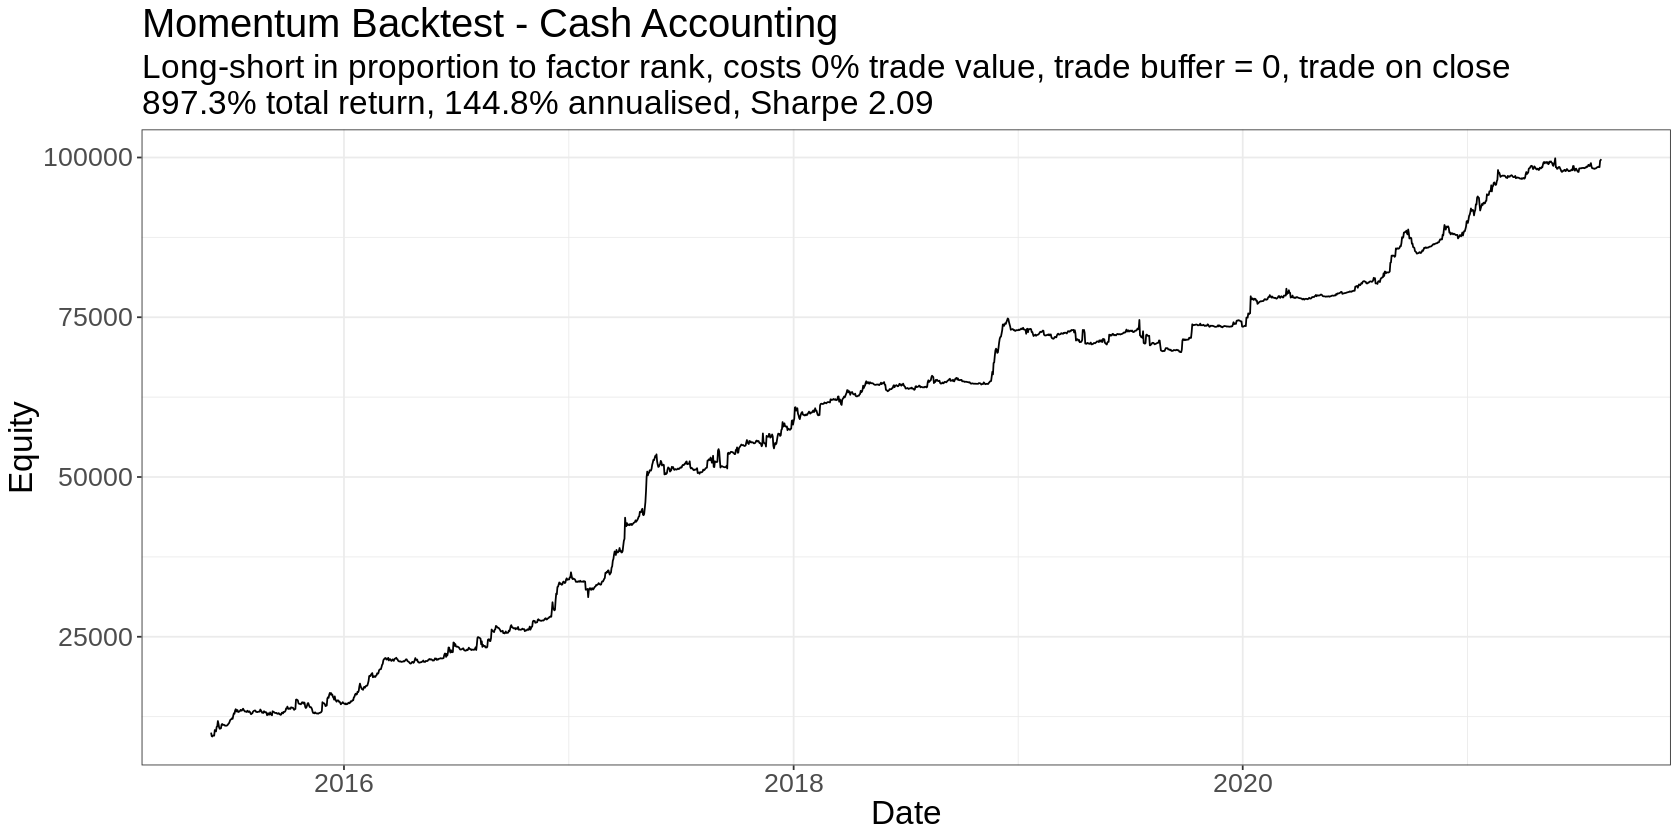

In [74]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
head(results_df)
plot_results(results_df)

### With costs, no trade buffer parameter

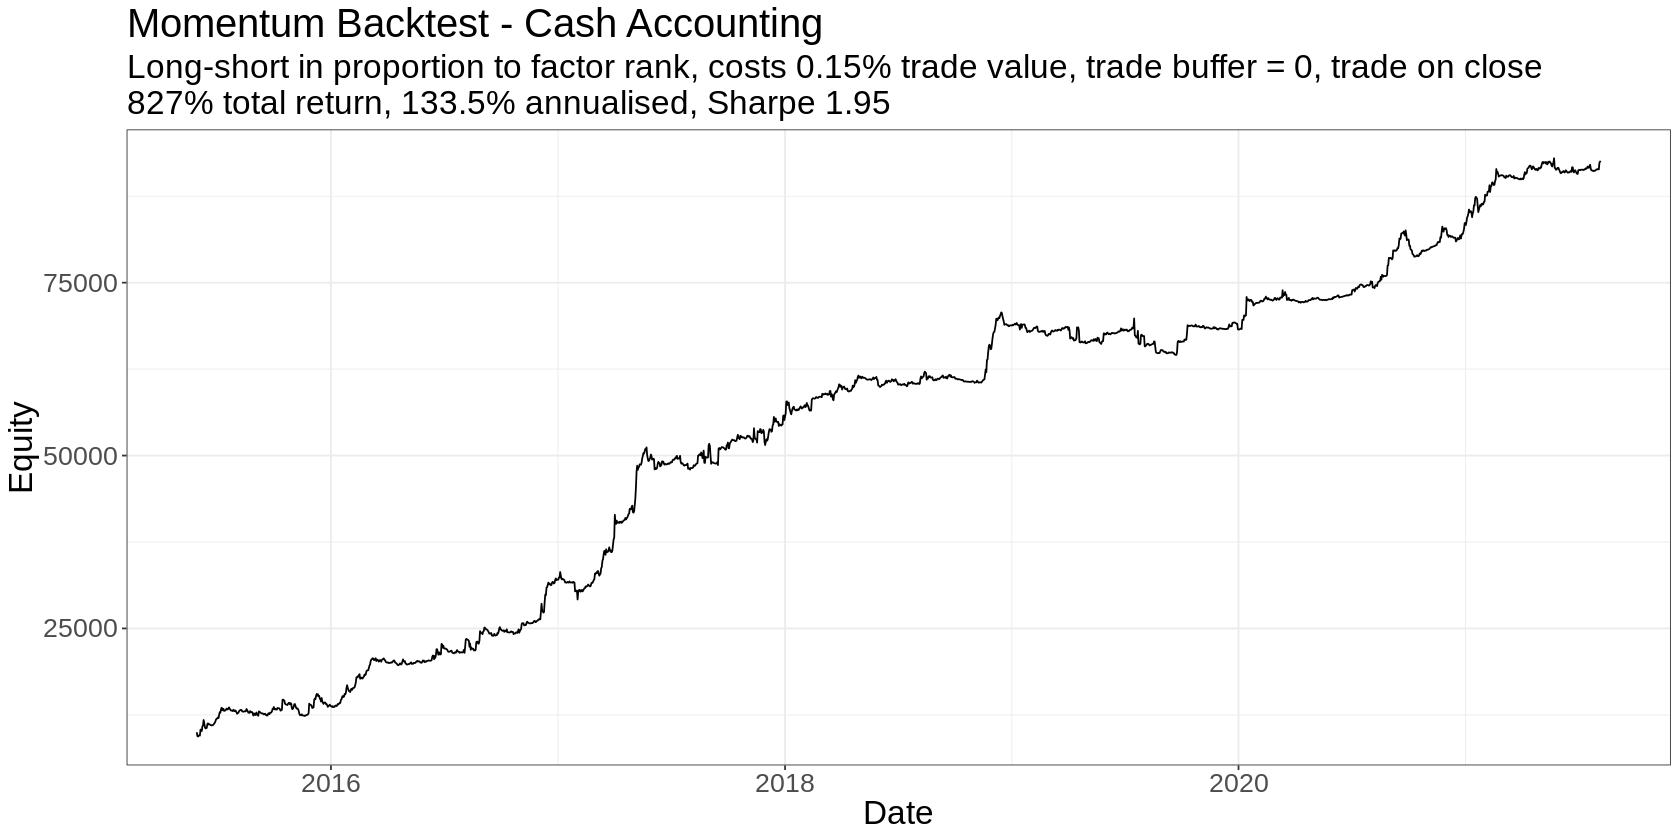

In [75]:
# simulation parameters
fee_tier <- 2.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
  plot_results()

Find an appropriate trade buffer parameter by optimising for sharpe ratio

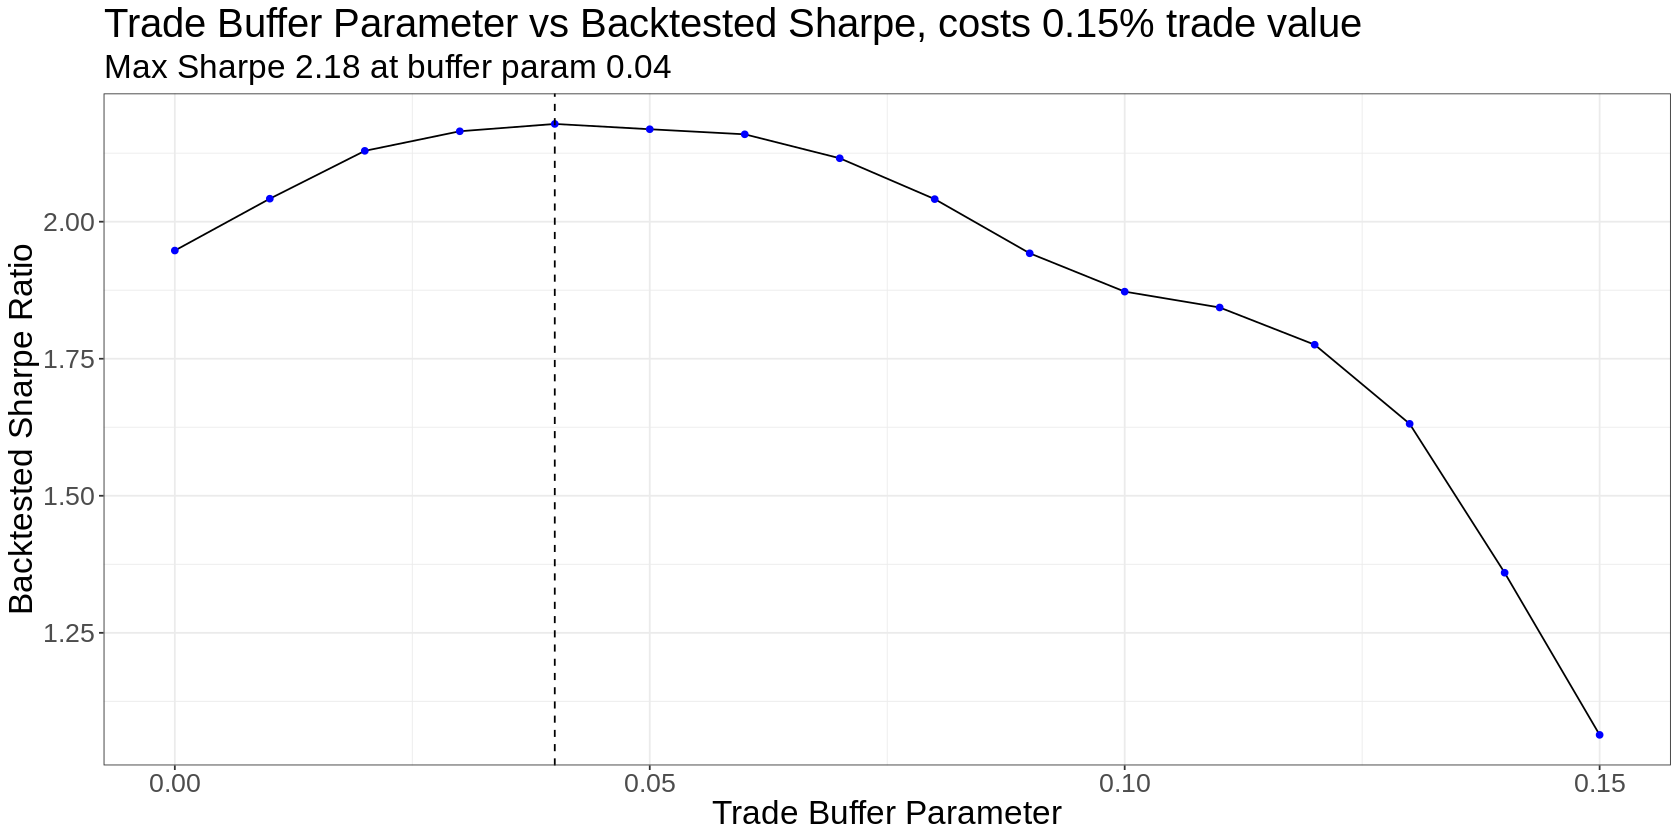

In [76]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(
      backtest_prices, 
      backtest_weights, 
      trade_buffer, 
      initial_cash, 
      commission_pct, 
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

### Backtest with optimal trade buffer

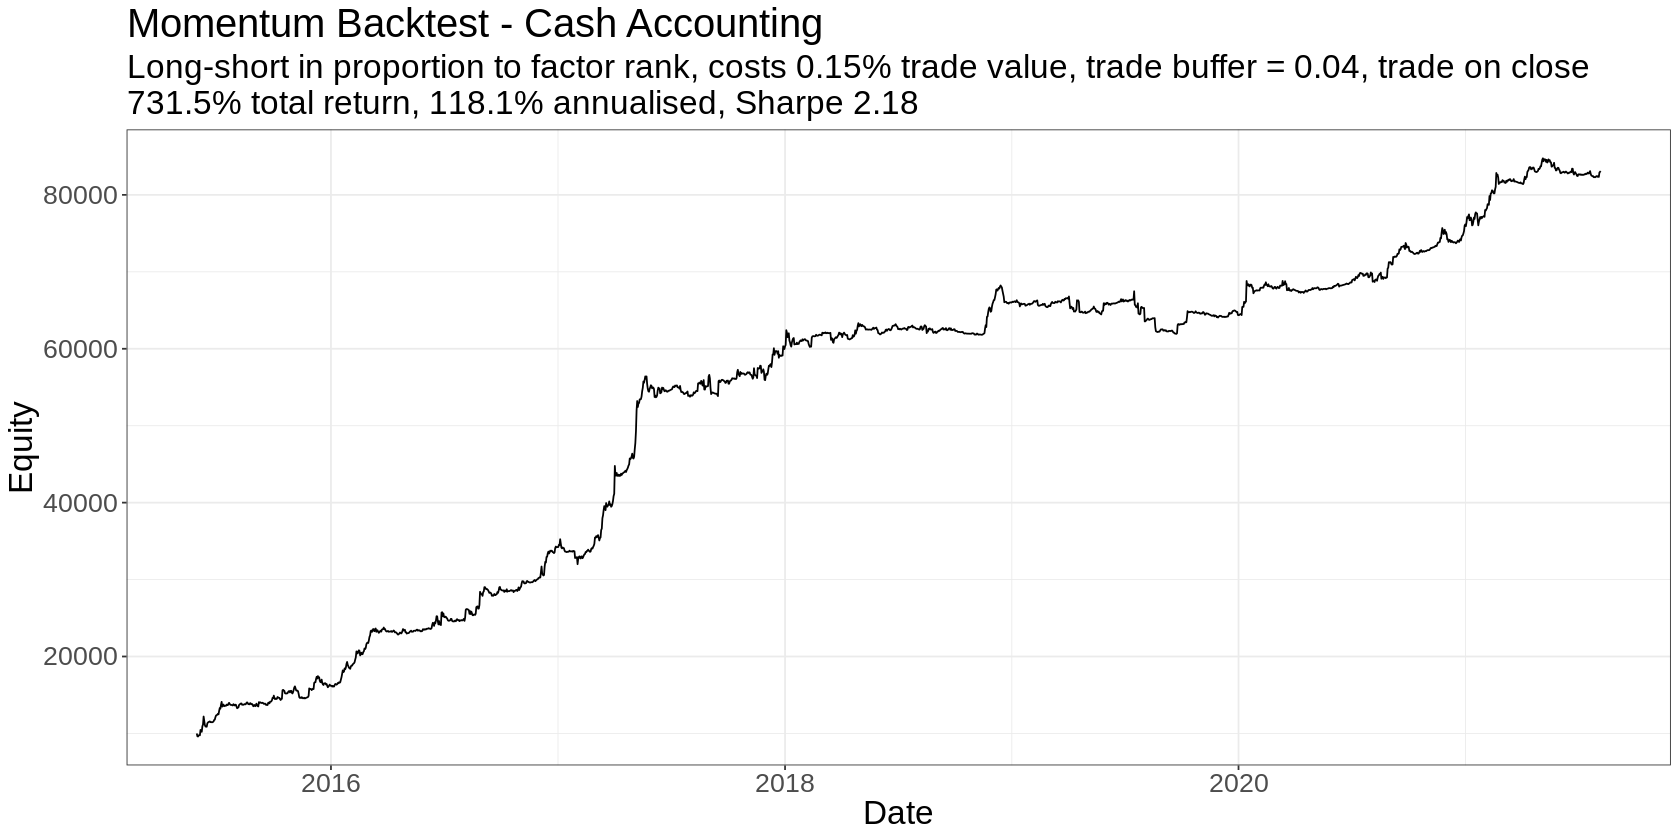

In [77]:
trade_buffer <- 0.04

cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
plot_results()

### What if we trade on the next day's close?


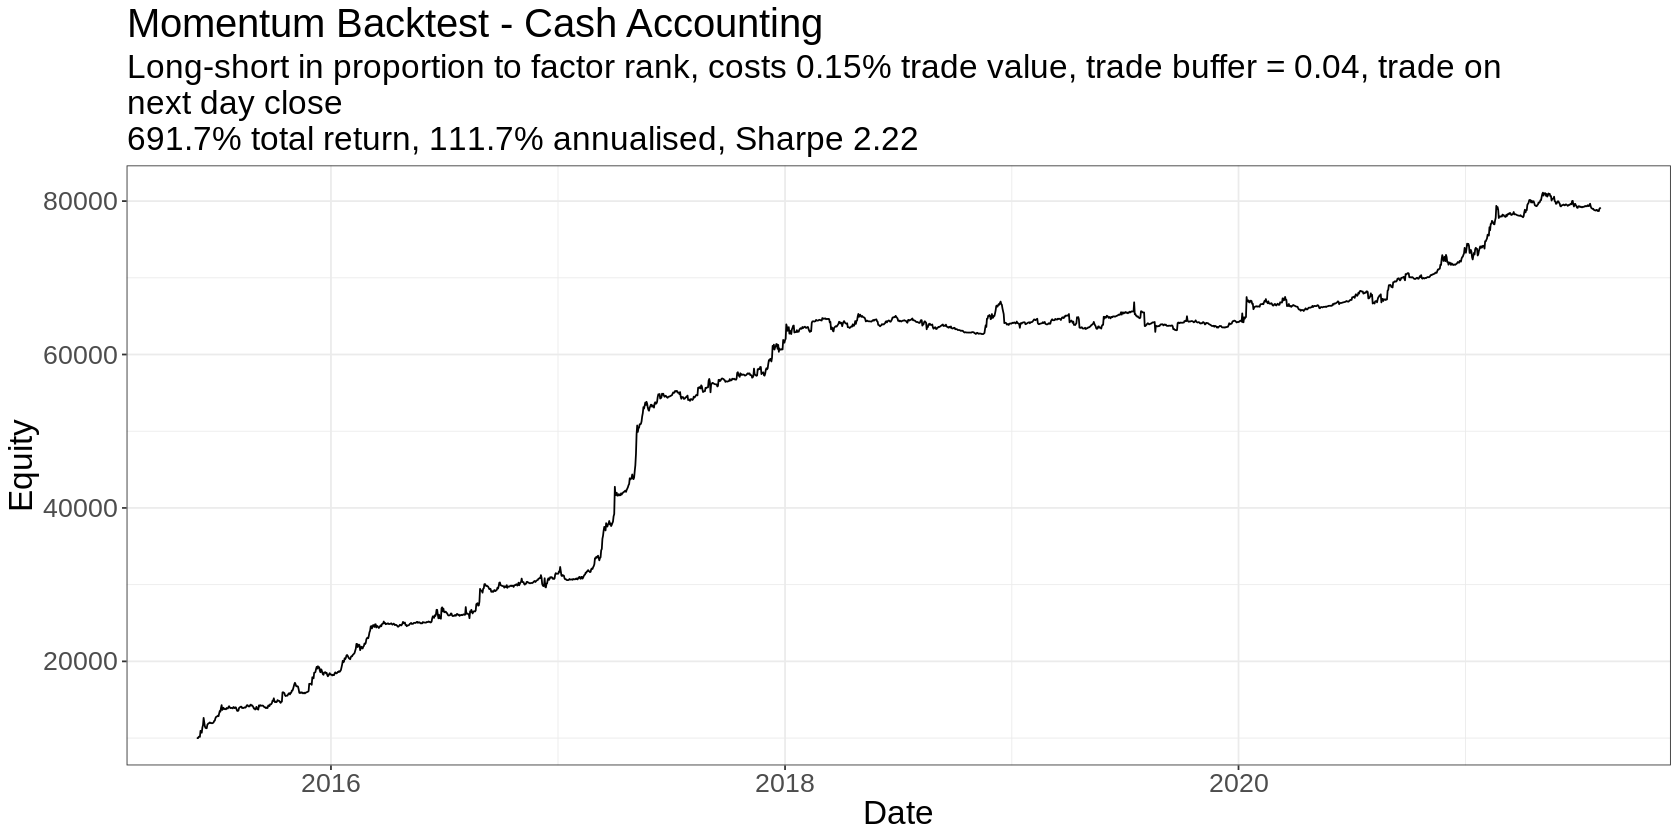

In [78]:
cash_backtest(
  backtest_prices, 
  # lag backtest weights with respect to prices
  backtest_weights %>% 
    as.data.frame() %>% 
    mutate(across(.cols = -date, .fns = dplyr::lag, n = 1)) %>% 
    data.matrix(), 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
  plot_results(trade_on = "\nnext day close")

Is there a different trade buffer trade-off if we assume trading on the next day's close?


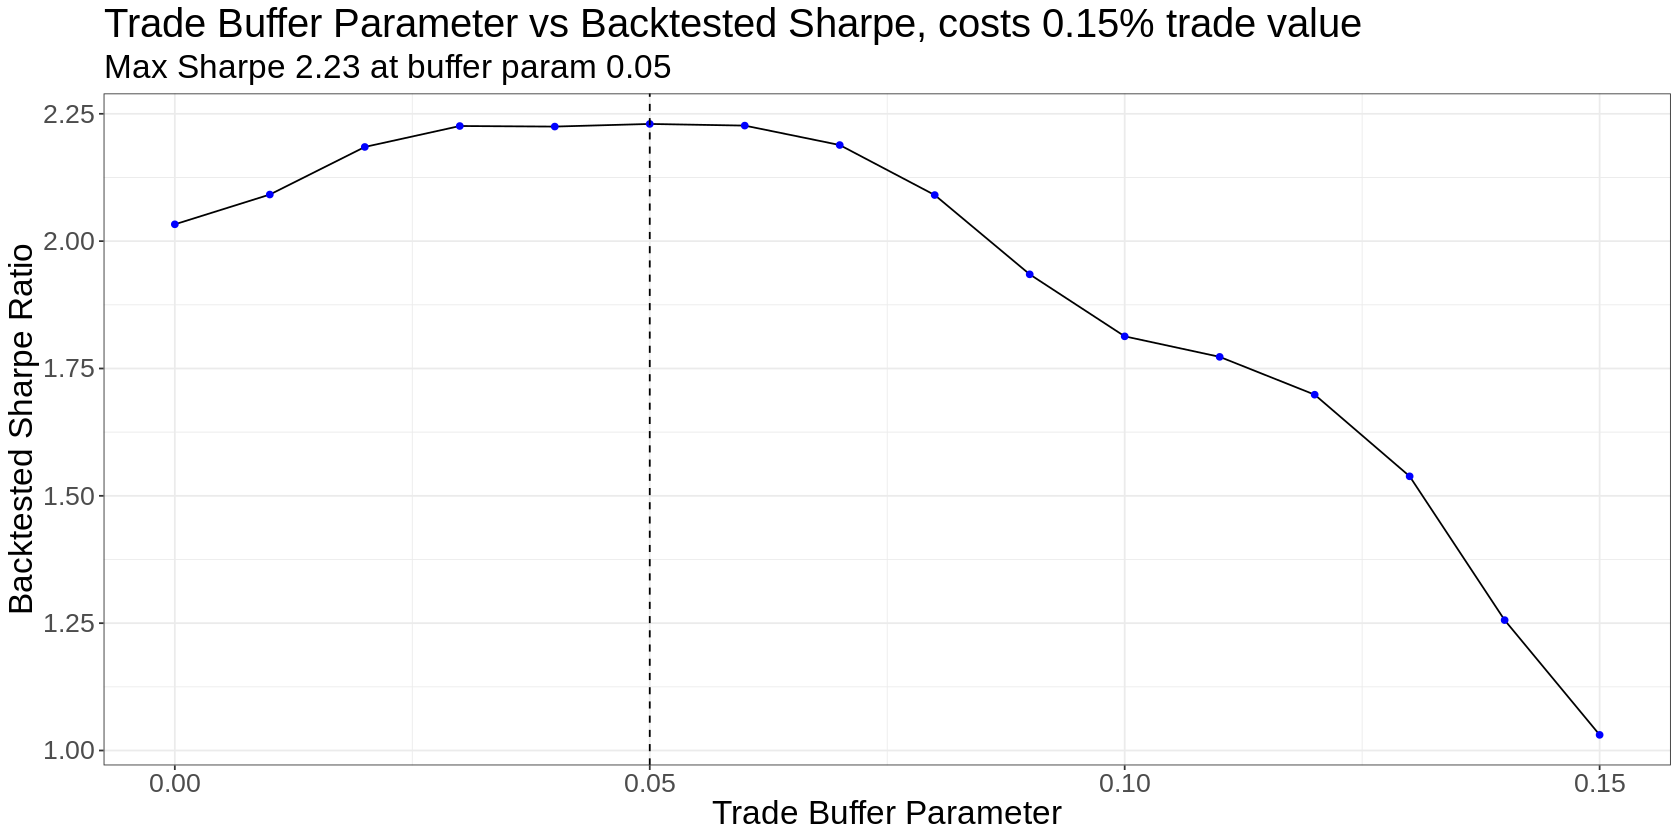

In [79]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(
      backtest_prices, 
      # lag backtest weights with respect to prices
      backtest_weights %>% 
        as.data.frame() %>% 
        mutate(across(.cols = -date, .fns = dplyr::lag, n = 1)) %>% 
        data.matrix(), 
      trade_buffer, 
      initial_cash, 
      commission_pct, 
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

The backtest is quite robust to the trade buffer parameter even if we assume trading on next day close.

Let's pick the optimal value anyway and simulate:

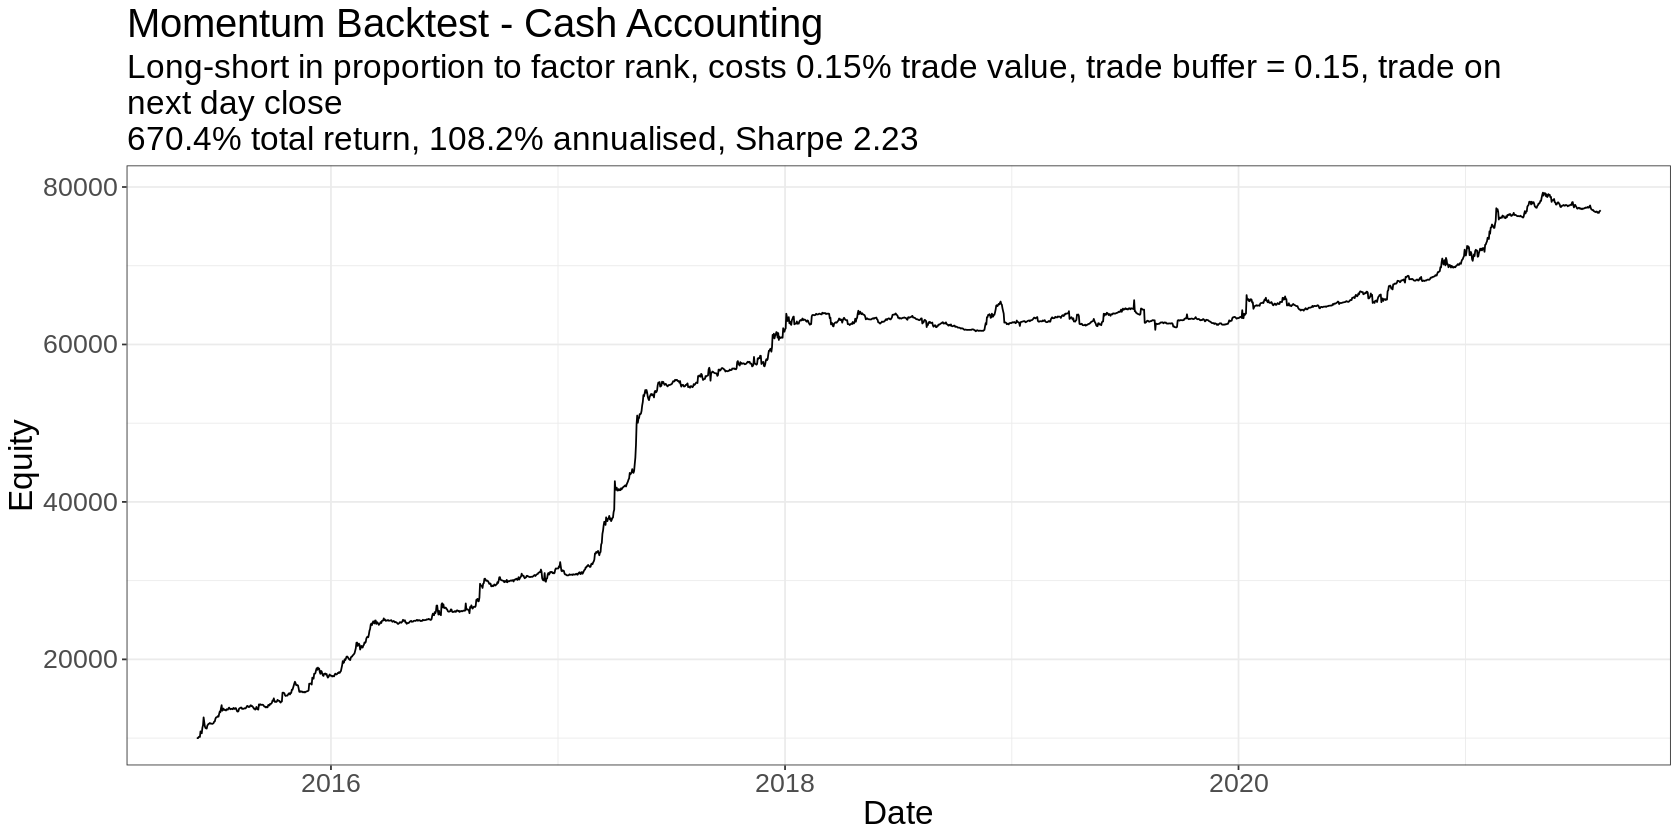

In [80]:
results_df <- cash_backtest(
  backtest_prices, 
  # lag backtest weights with respect to prices
  backtest_weights %>% 
    as.data.frame() %>% 
    mutate(across(.cols = -date, .fns = dplyr::lag, n = 1)) %>% 
    data.matrix(), 
  trade_buffer = 0.05, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
)  
plot_results(results_df, trade_on = "\nnext day close")

Check how much we trade - use traded value by coin by date

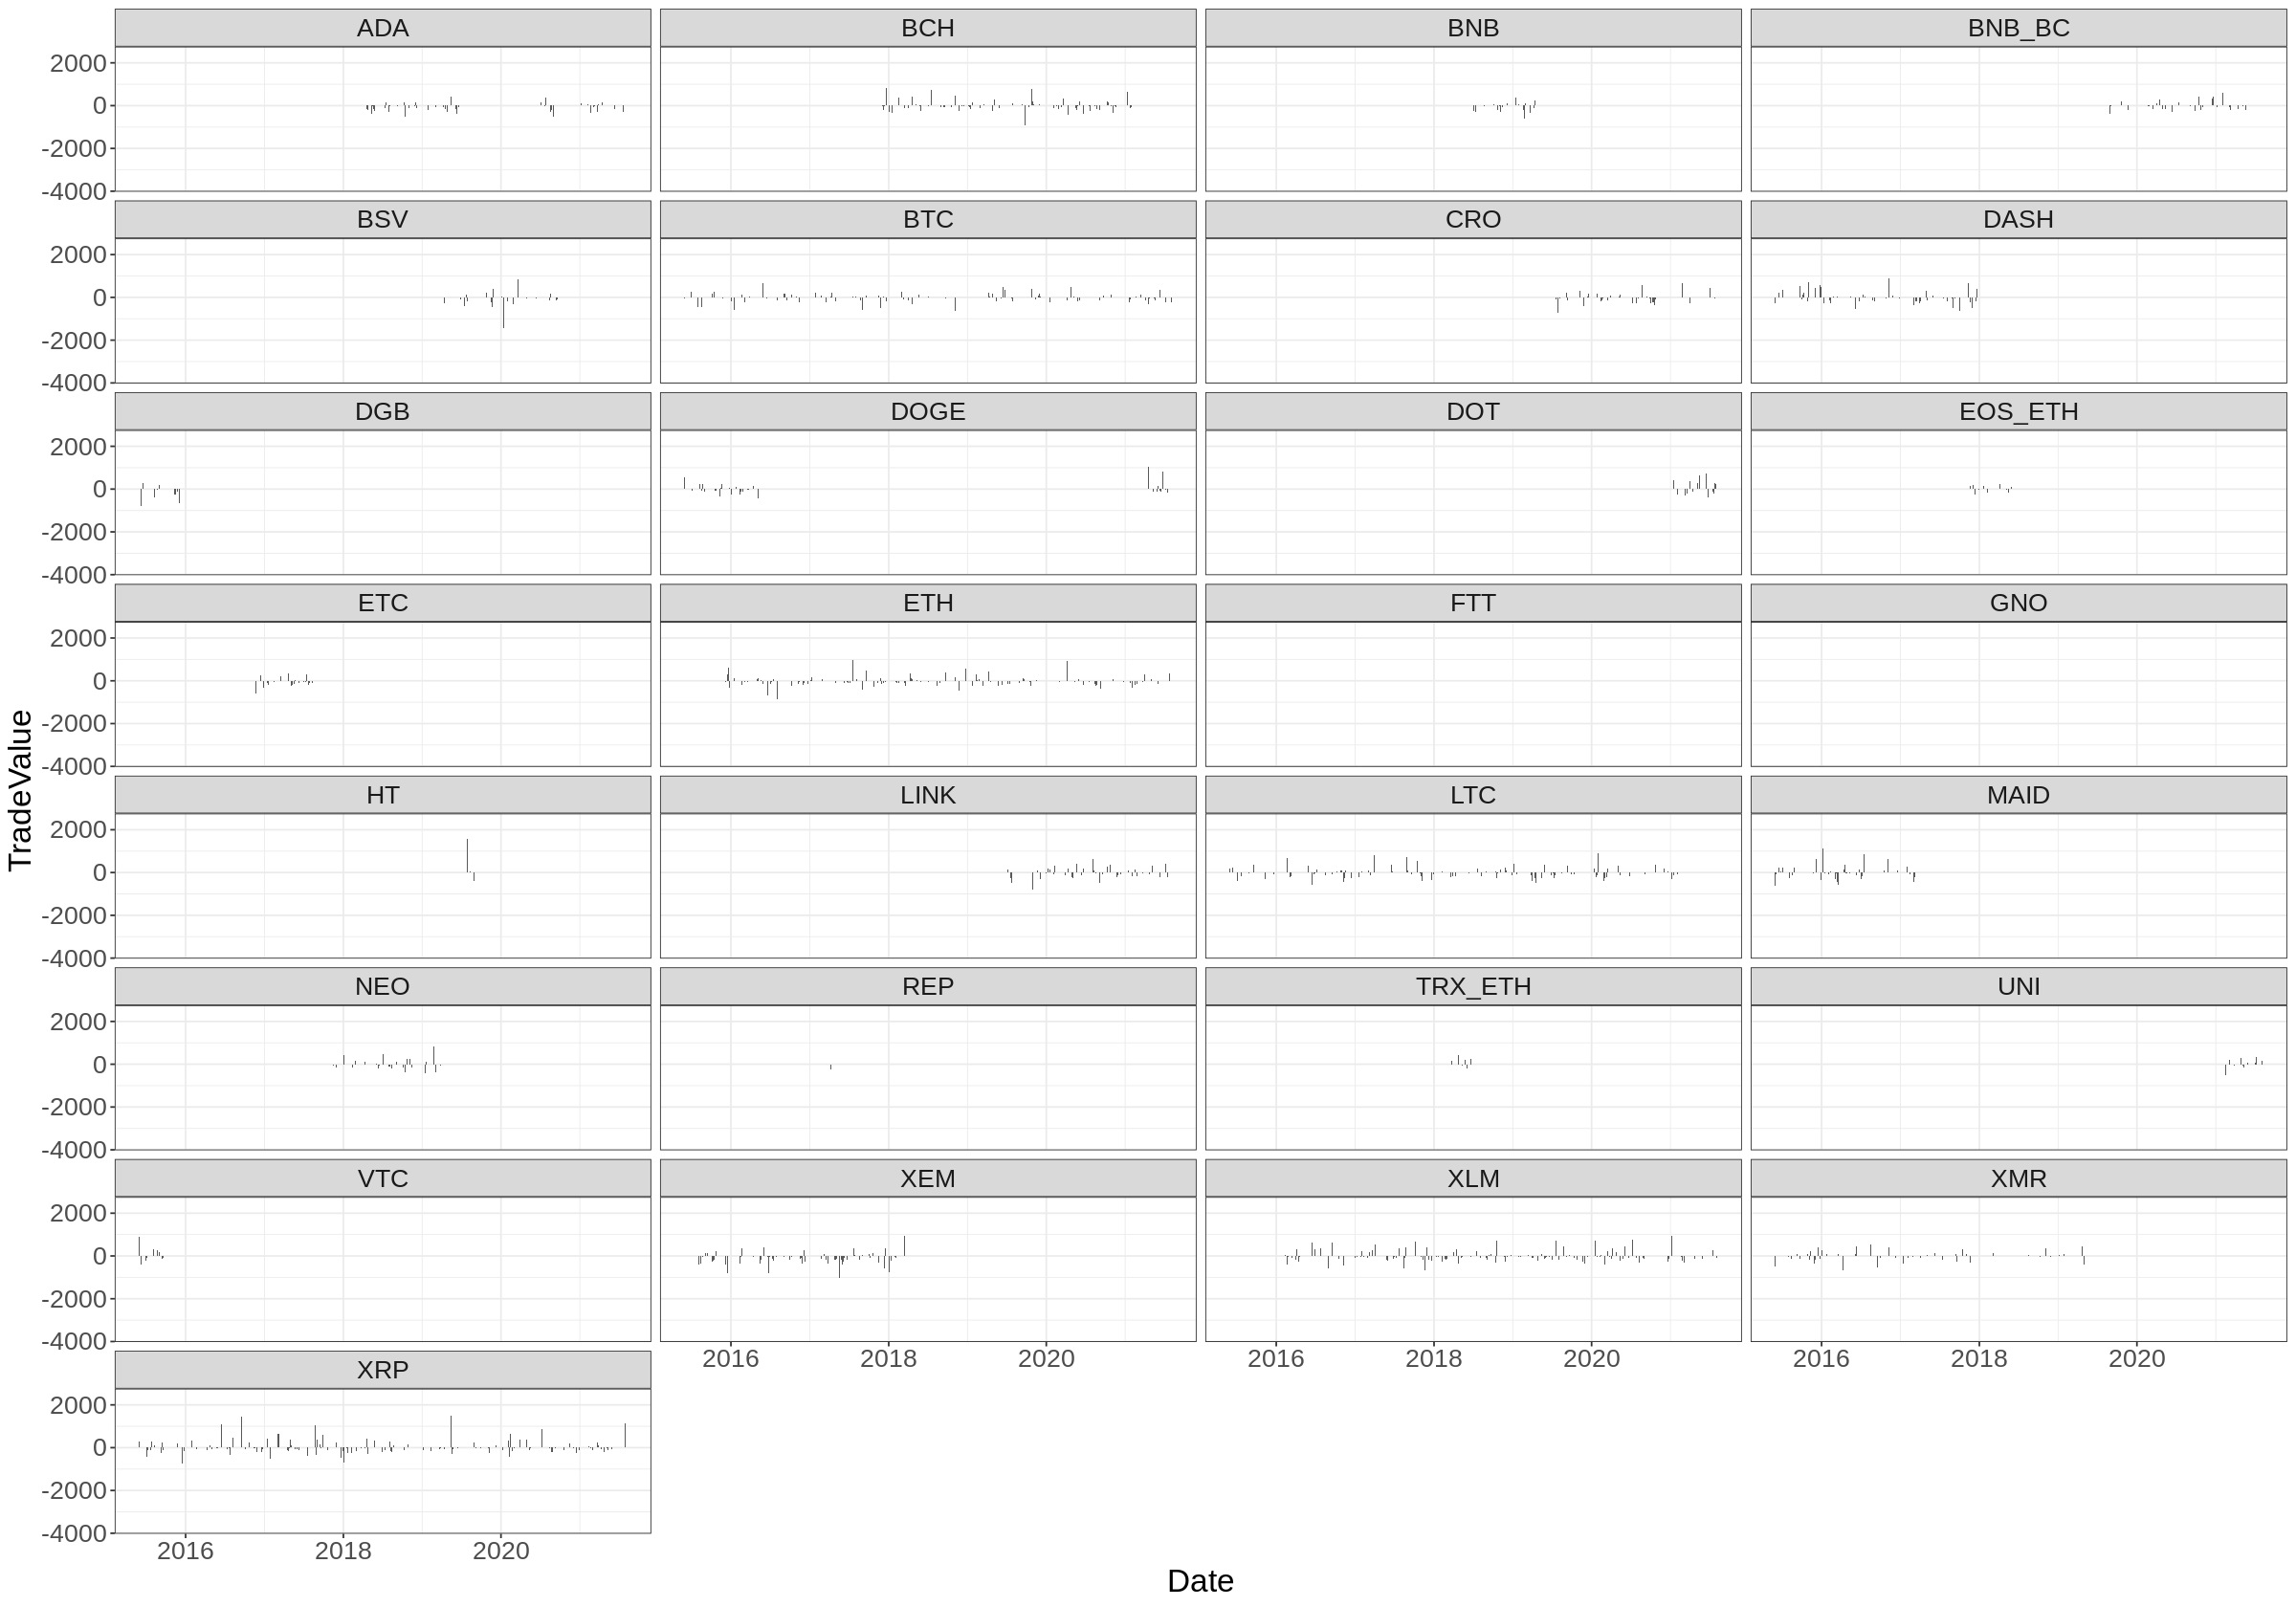

In [81]:
# need a bigger plot
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

Major coins:

Warning message:
“Removed 1817 rows containing missing values (position_stack).”


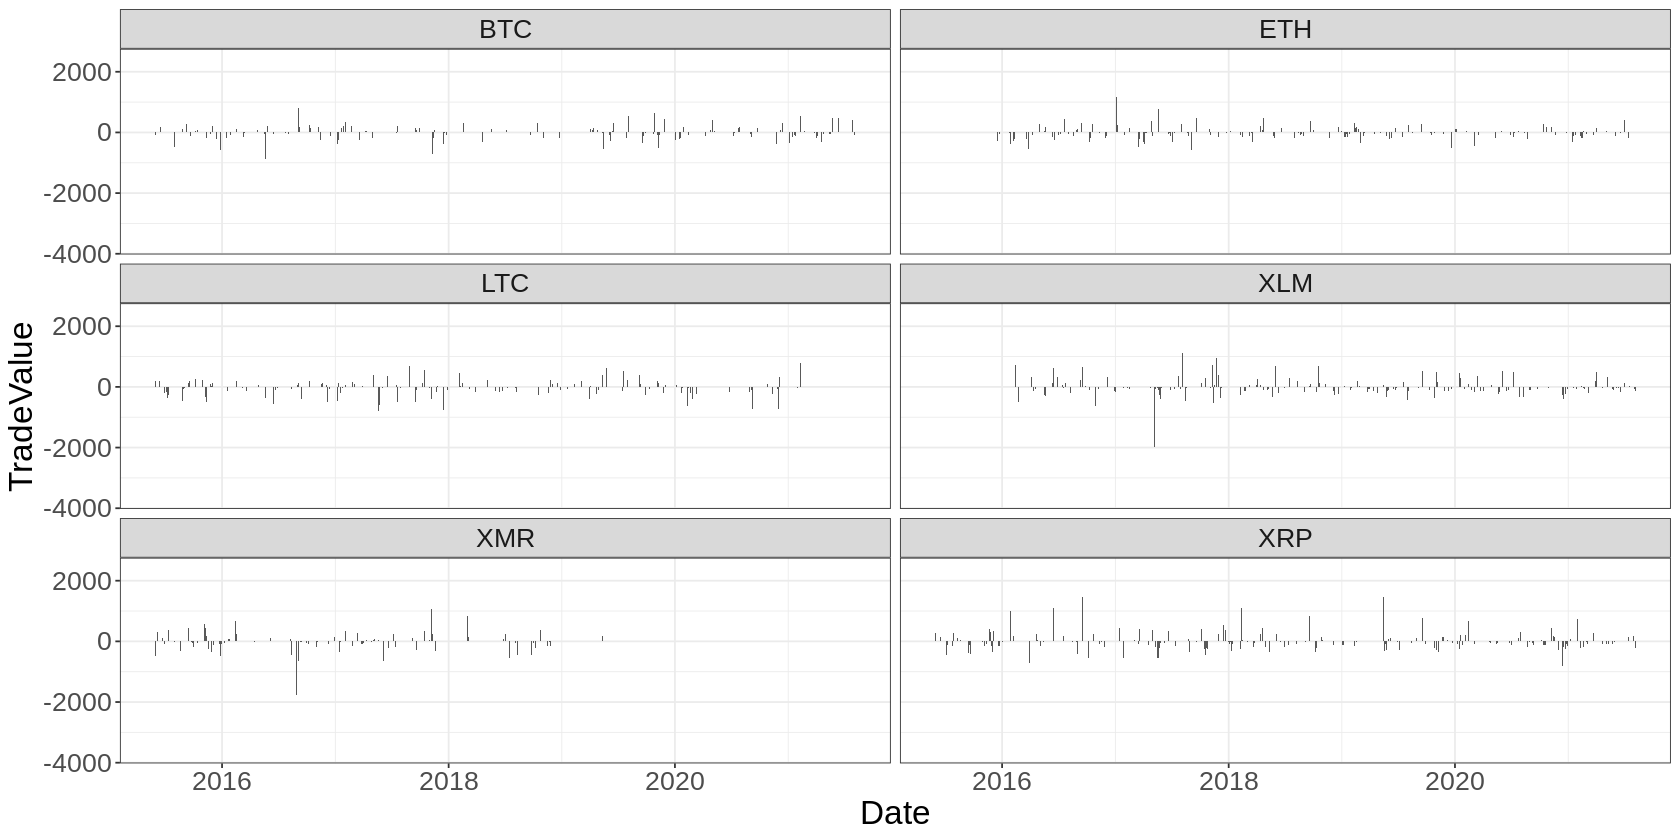

In [82]:
results_df %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Zoomed in to a month:

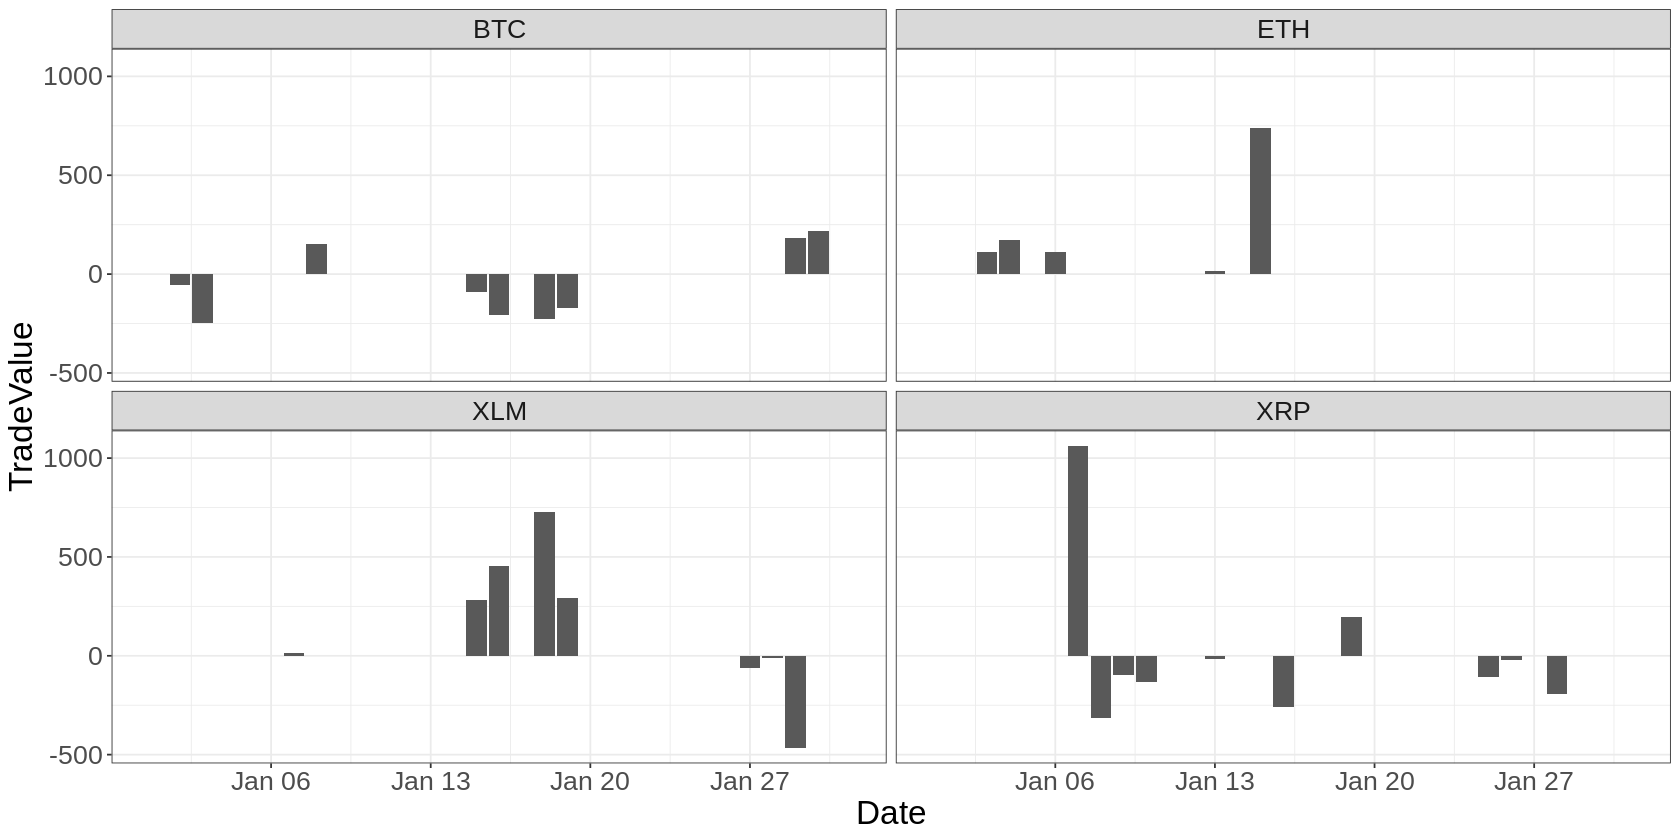

In [83]:
results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"), 
    Date >= "2020-01-01", 
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Compare with no trade buffer:

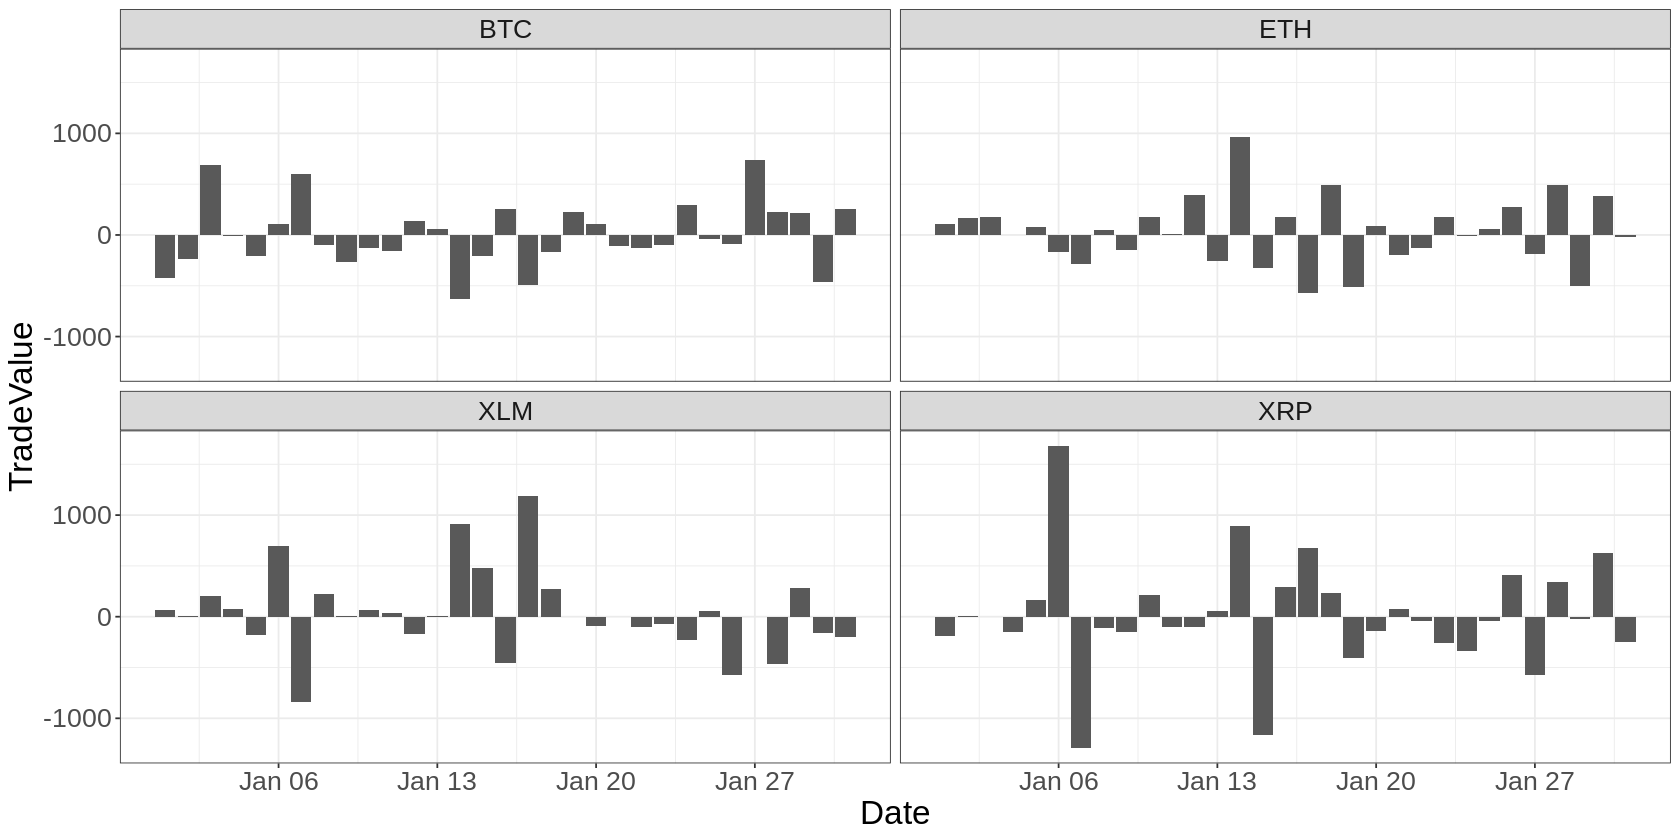

In [84]:
results_df <- cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer = 0., 
  initial_cash, 
  commission_pct, 
  capitalise_profits
)

results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"), 
    Date >= "2020-01-01", 
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

## Long-Only Simulations

### Cost-free, no trade buffer

In [85]:
longonly_df <- readRDS("/longonly.RDS")
head(longonly_df)

# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("weight_")) %>% 
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- longshort_df %>% 
  pivot_wider(names_from = ticker, values_from = c(price_usd, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("price_")) %>% 
  data.matrix()

head(backtest_prices, c(5, 5))

date,ticker,price_usd,weight
<date>,<chr>,<dbl>,<dbl>
2015-05-30,BTC,2.327888e+02,-0.06564839
2015-05-30,DASH,2.664557e+00,-0.09265479
2015-05-30,DOGE,1.608110e-04,0.12529065
2015-05-30,LTC,1.775243e+00,0.08763449
2015-05-30,MAID,1.648093e-02,-0.13662925
2015-05-30,VTC,1.330717e-01,0.16802941


date,weight_BTC,weight_DASH,weight_DOGE,weight_LTC
16585,-0.05700716,-0.078953728,0.10287028,0.06920005
16586,-0.09730337,-0.031711833,0.09927975,0.01649150
16587,-0.12047438,-0.084581304,0.09368680,0.01910613
16588,-0.11199627,-0.002653652,0.10660911,0.02116289
16589,-0.10140447,-0.039967146,0.08082606,0.04064897


date,price_usd_BTC,price_usd_DASH,price_usd_DOGE,price_usd_LTC
16585,232.7888,2.664557,0.0001608110,1.775243
16586,229.4505,2.782353,0.0001520976,1.626112
16587,223.2827,2.658373,0.0001464737,1.601772
16588,225.3208,2.821253,0.0001610622,1.659014
16589,225.2131,2.725180,0.0001516551,1.688960


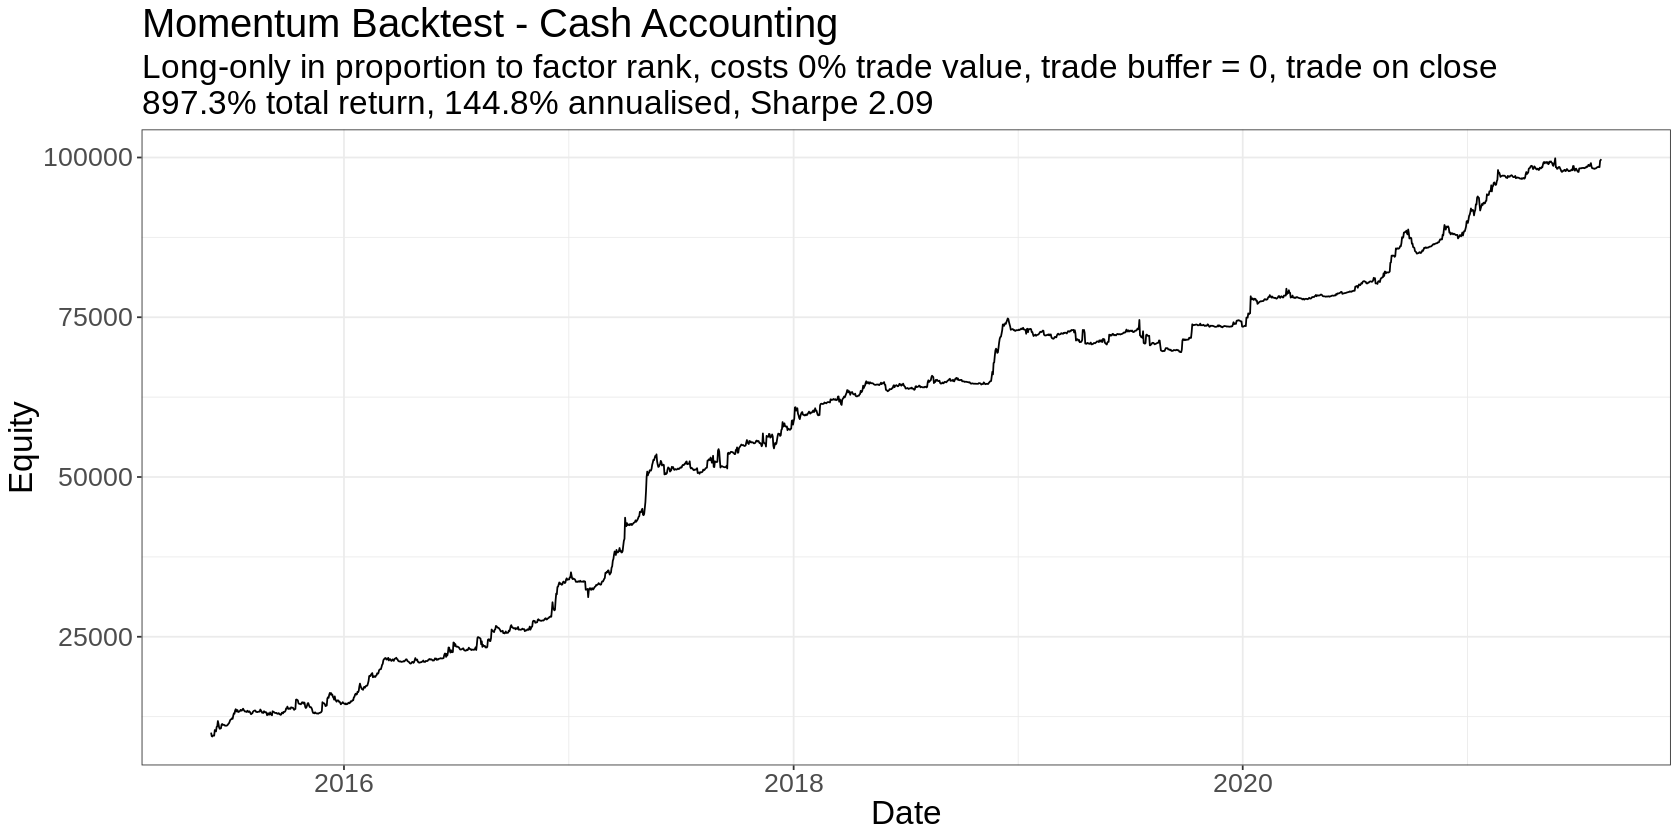

In [86]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>%
  plot_results(weighting_protocol = "Long-only in proportion to factor rank")

### With costs, no trade buffer:

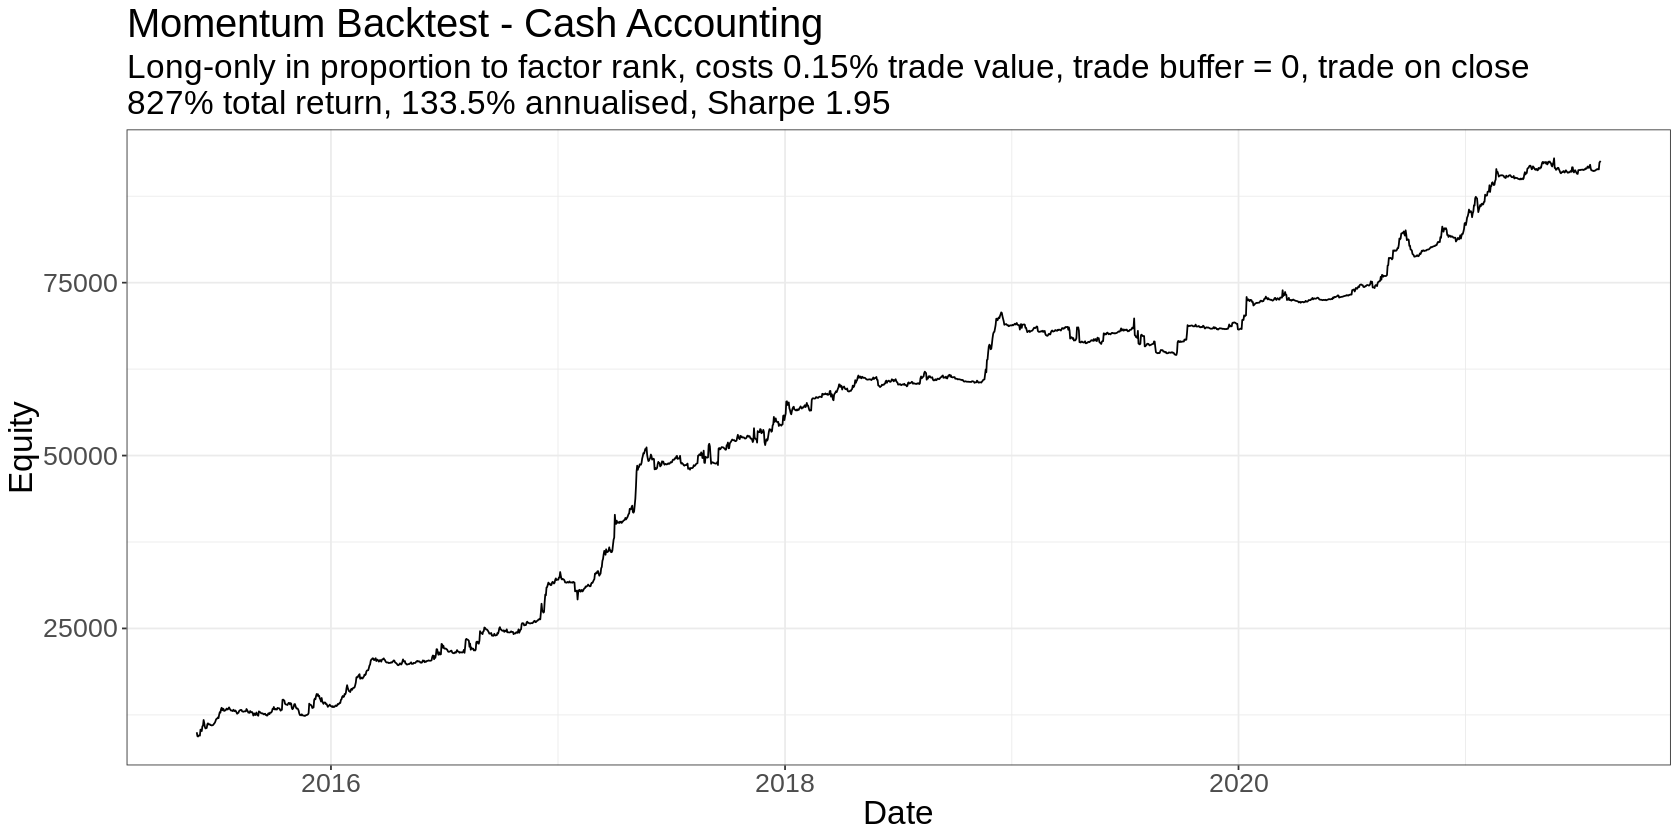

In [87]:
# simulation parameters
fee_tier <- 2.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
  plot_results(weighting_protocol = "Long-only in proportion to factor rank")

### Find an appropriate trade buffer parameter

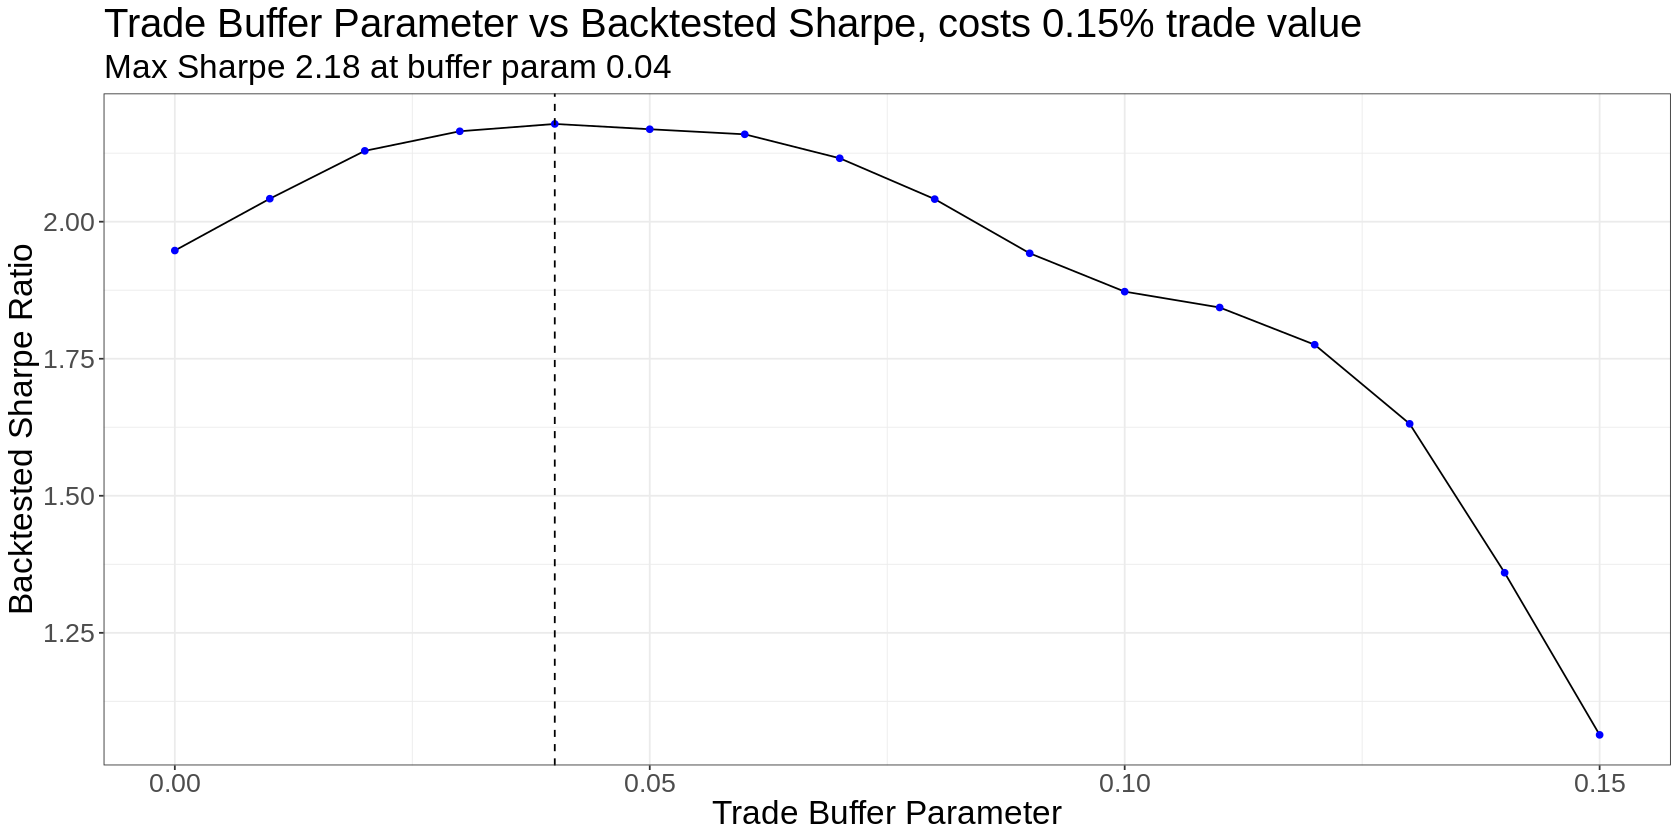

In [88]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes, 
    cash_backtest(
      backtest_prices, 
      backtest_weights, 
      trade_buffer, 
      initial_cash, 
      commission_pct, 
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers, 
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

### Backtest with optimal trade buffer

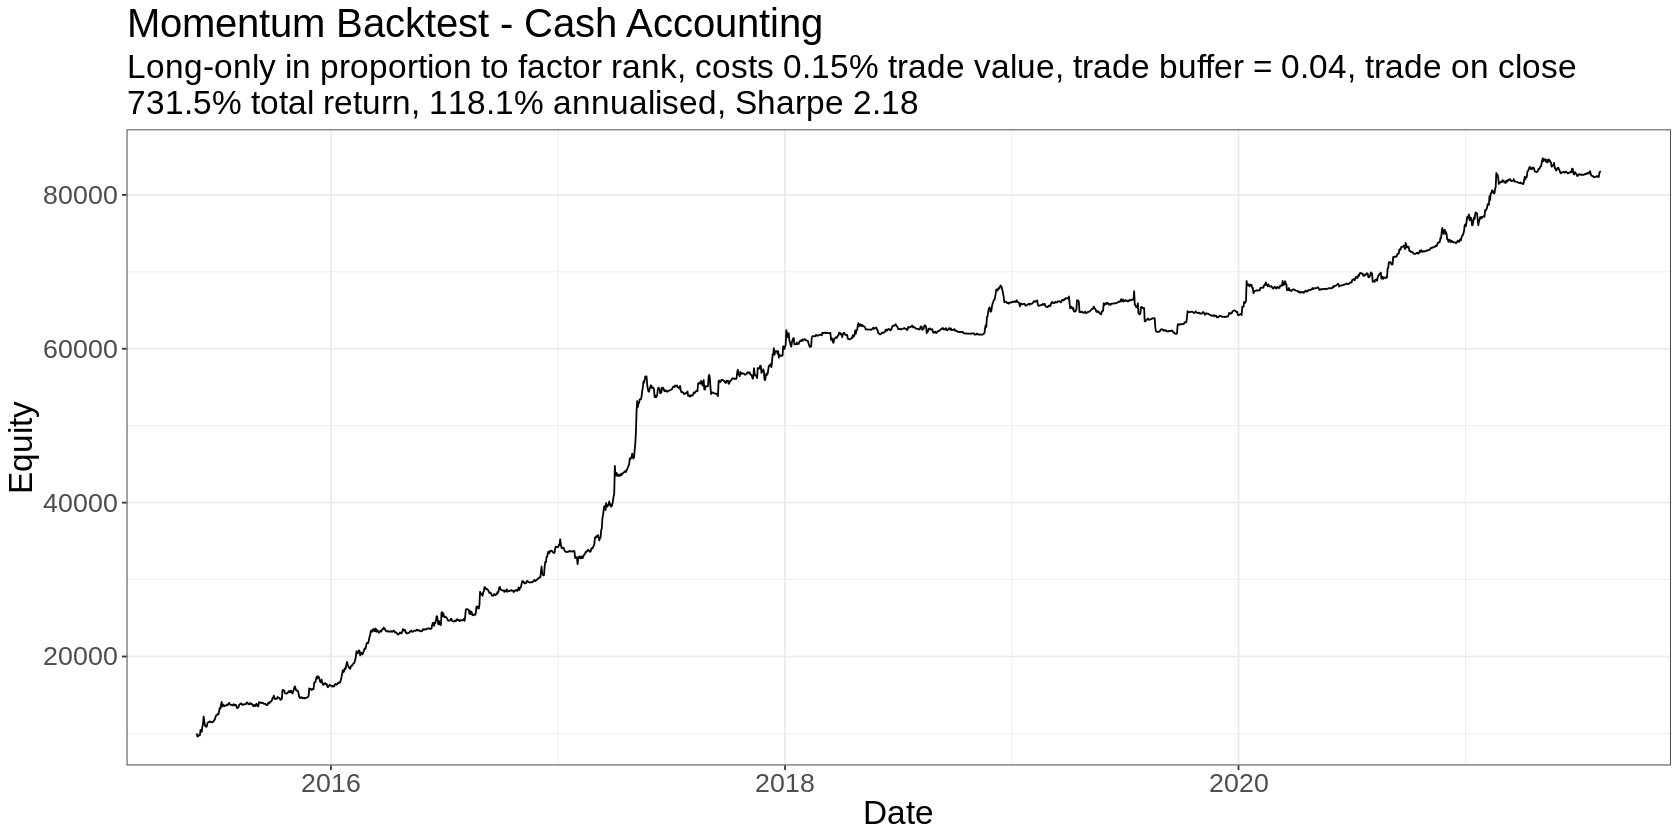

In [89]:
trade_buffer <- 0.04

cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) %>% 
  plot_results(weighting_protocol = "Long-only in proportion to factor rank")

### What if we trade on next day's close?

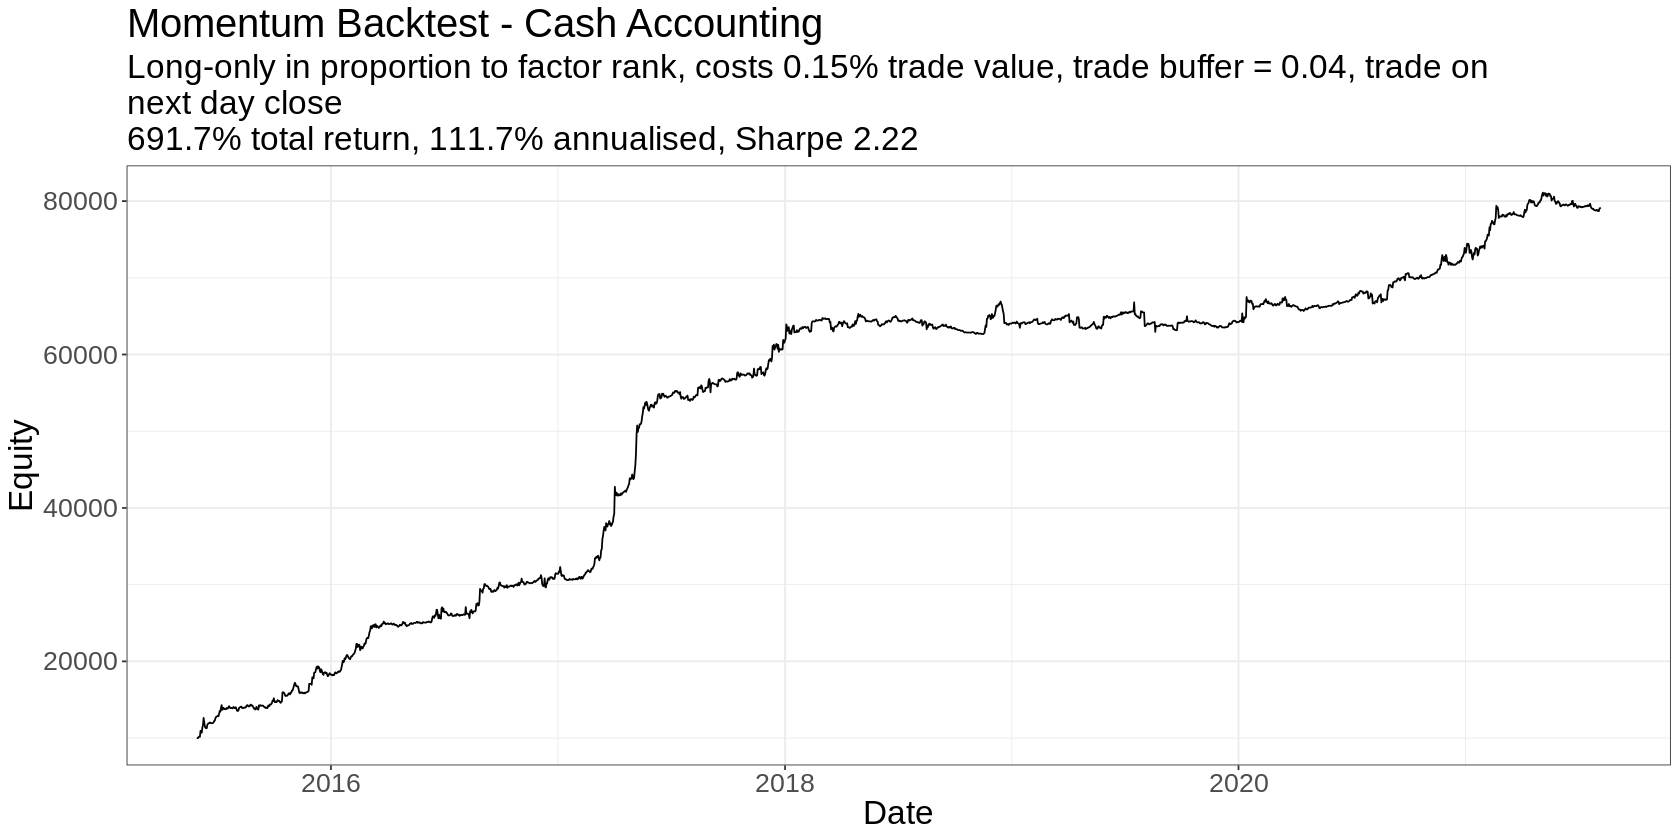

In [90]:
results_df <- cash_backtest(
  backtest_prices, 
  # lag backtest weights with respect to prices
  backtest_weights %>% 
    as.data.frame() %>% 
    mutate(across(.cols = -date, .fns = dplyr::lag, n = 1)) %>% 
    data.matrix(), 
  trade_buffer, 
  initial_cash, 
  commission_pct, 
  capitalise_profits
) 

plot_results(
  results_df,
  weighting_protocol = "Long-only in proportion to factor rank", 
  trade_on = "\nnext day close"
)

Check how much we trade - use traded value by coin by date

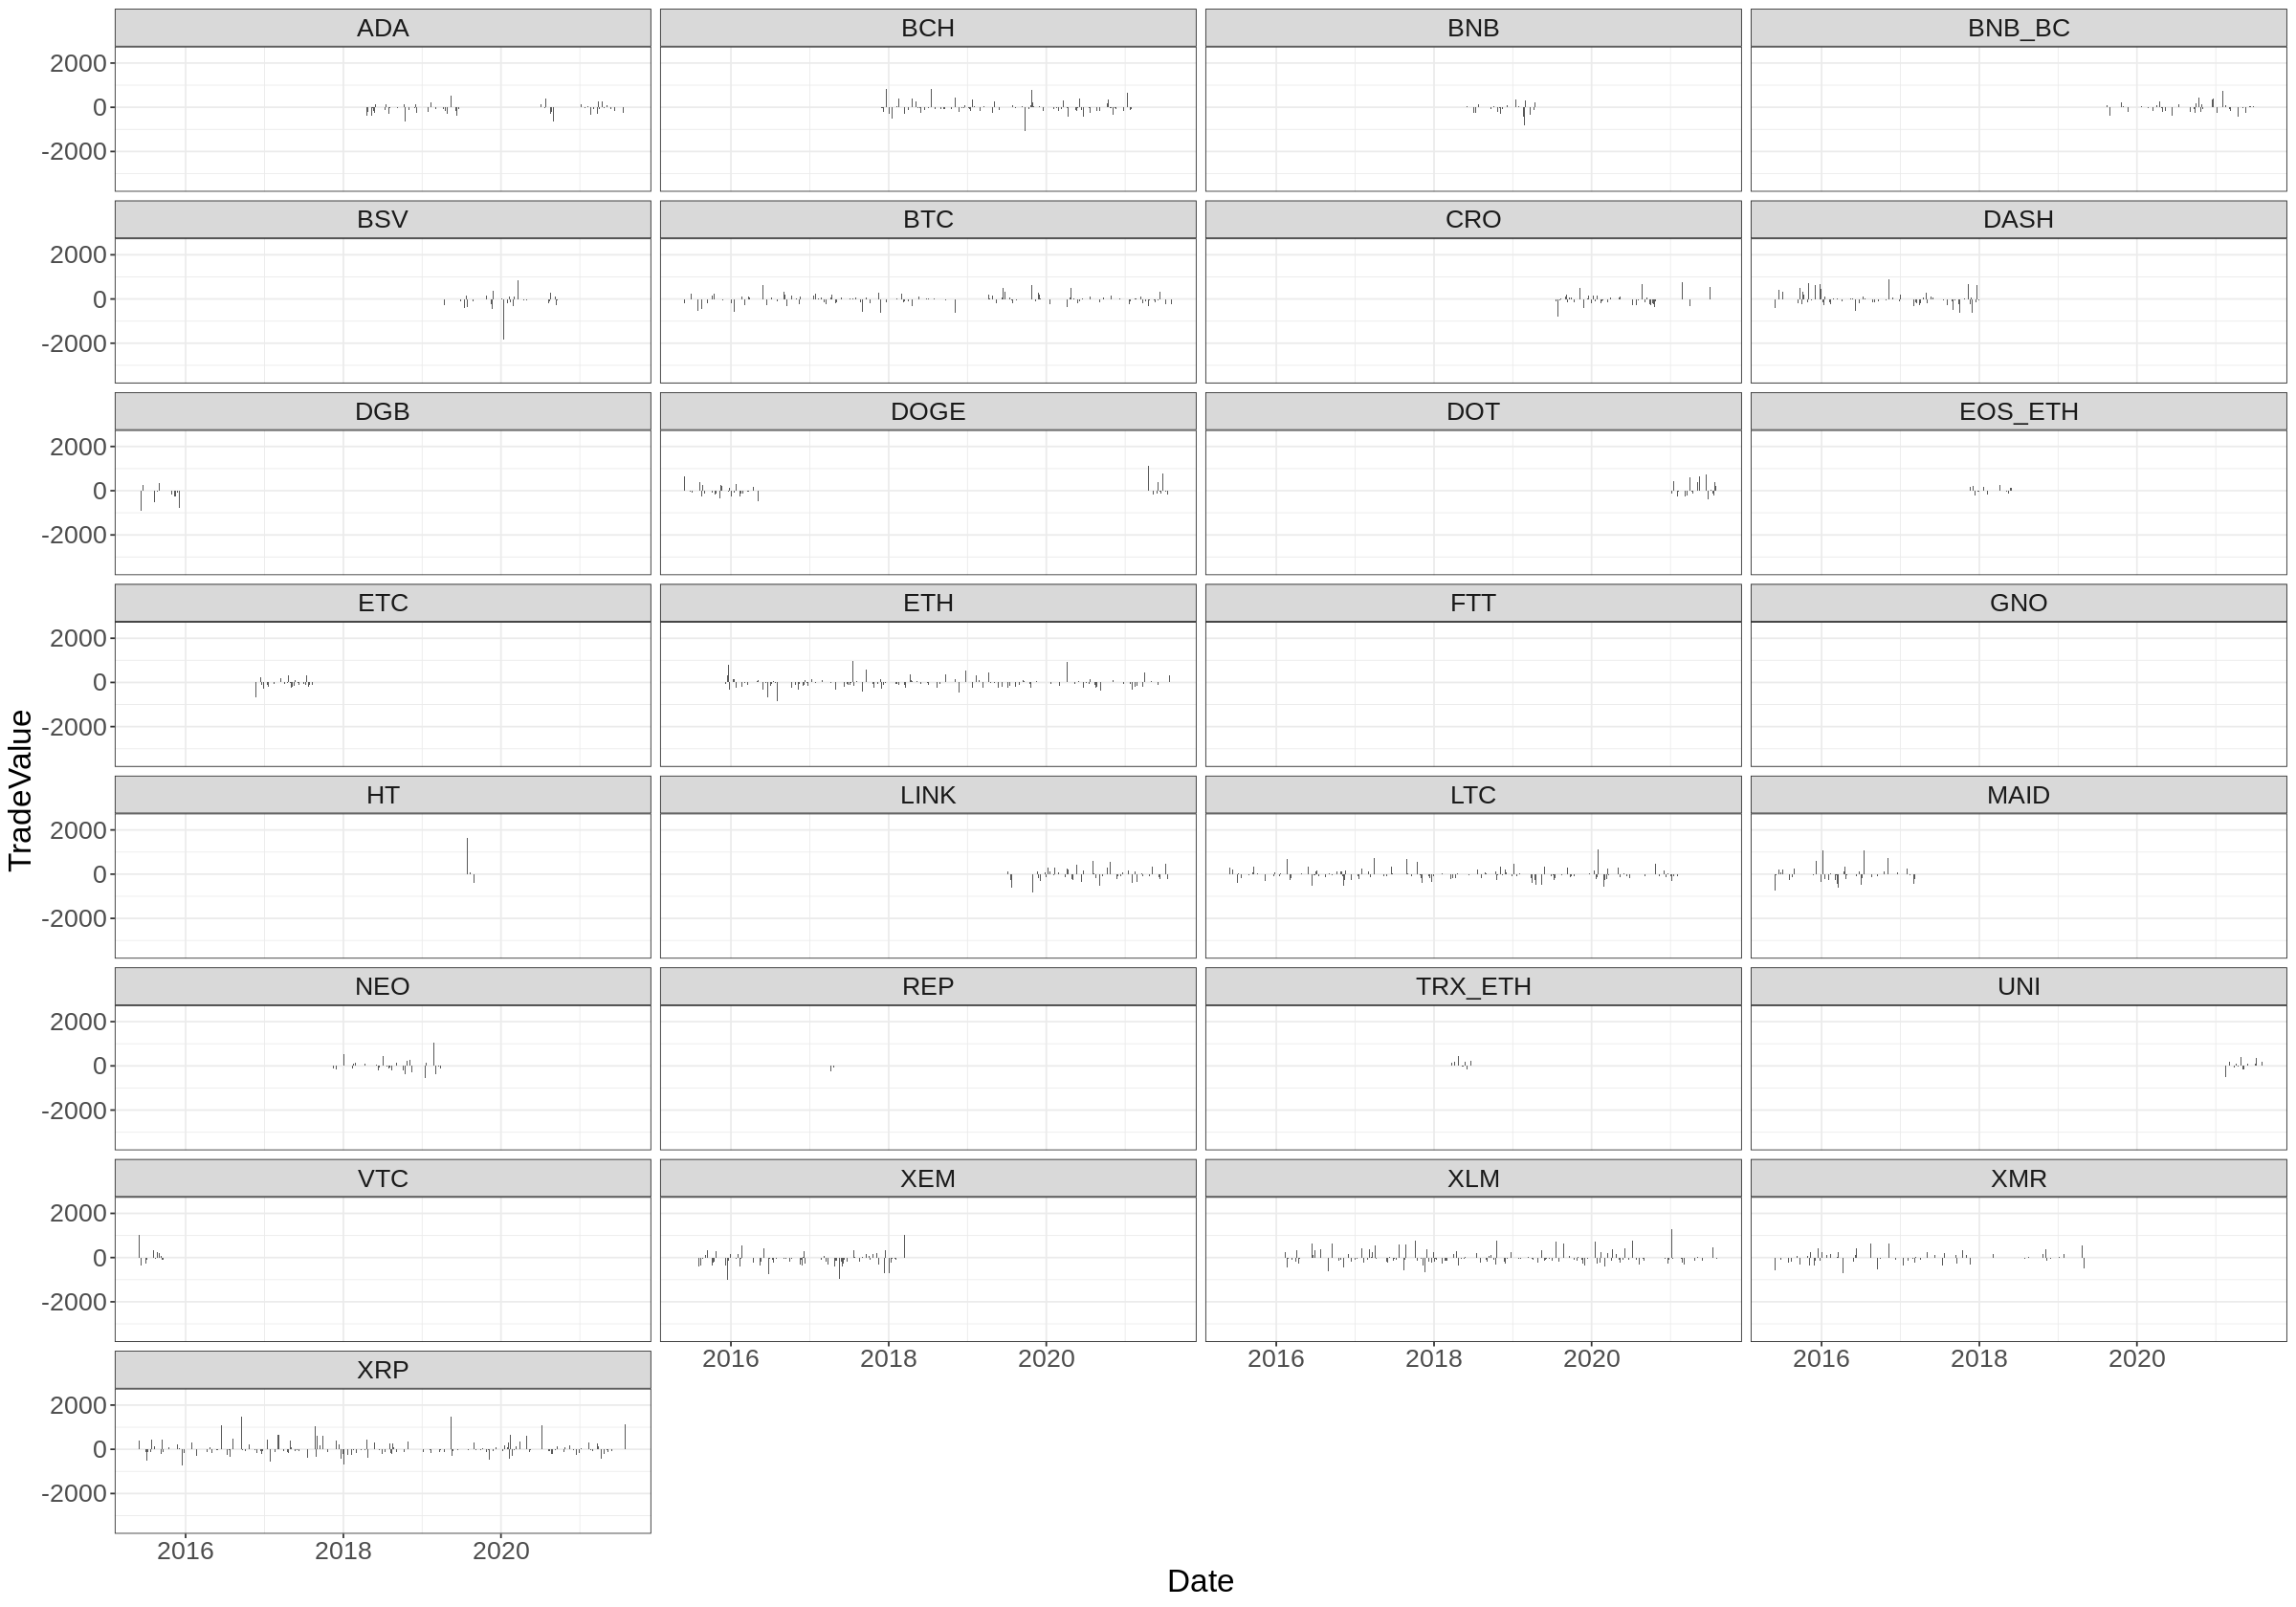

In [91]:
# need a bigger plot
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

Major coins:

Warning message:
“Removed 1817 rows containing missing values (position_stack).”


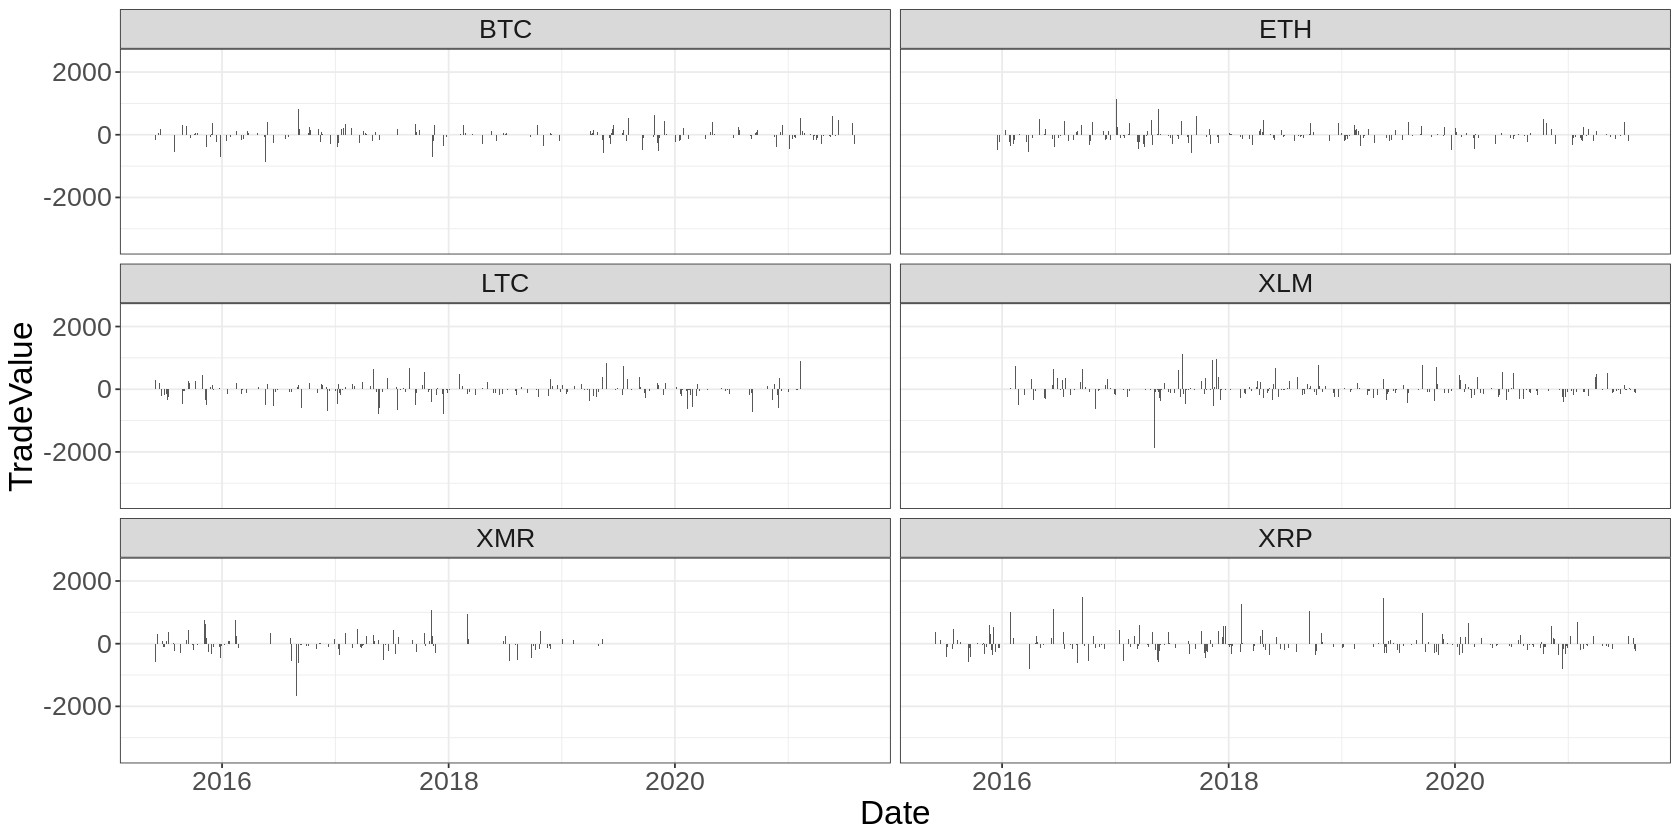

In [92]:
results_df %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Zoomed in to a month:

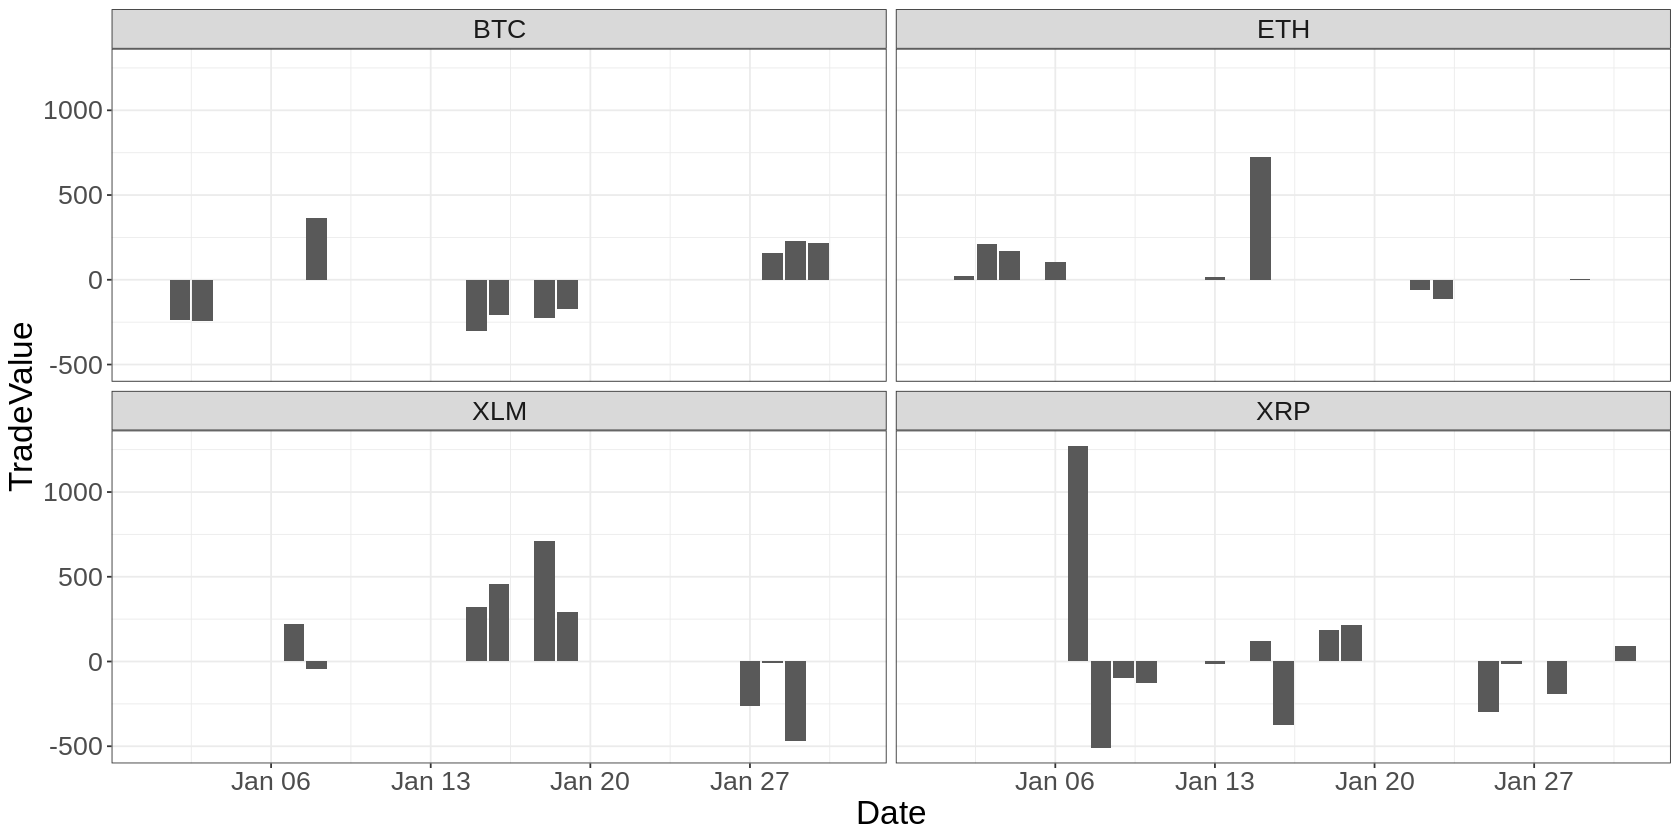

In [93]:
results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"), 
    Date >= "2020-01-01", 
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Compare with no trade buffer:

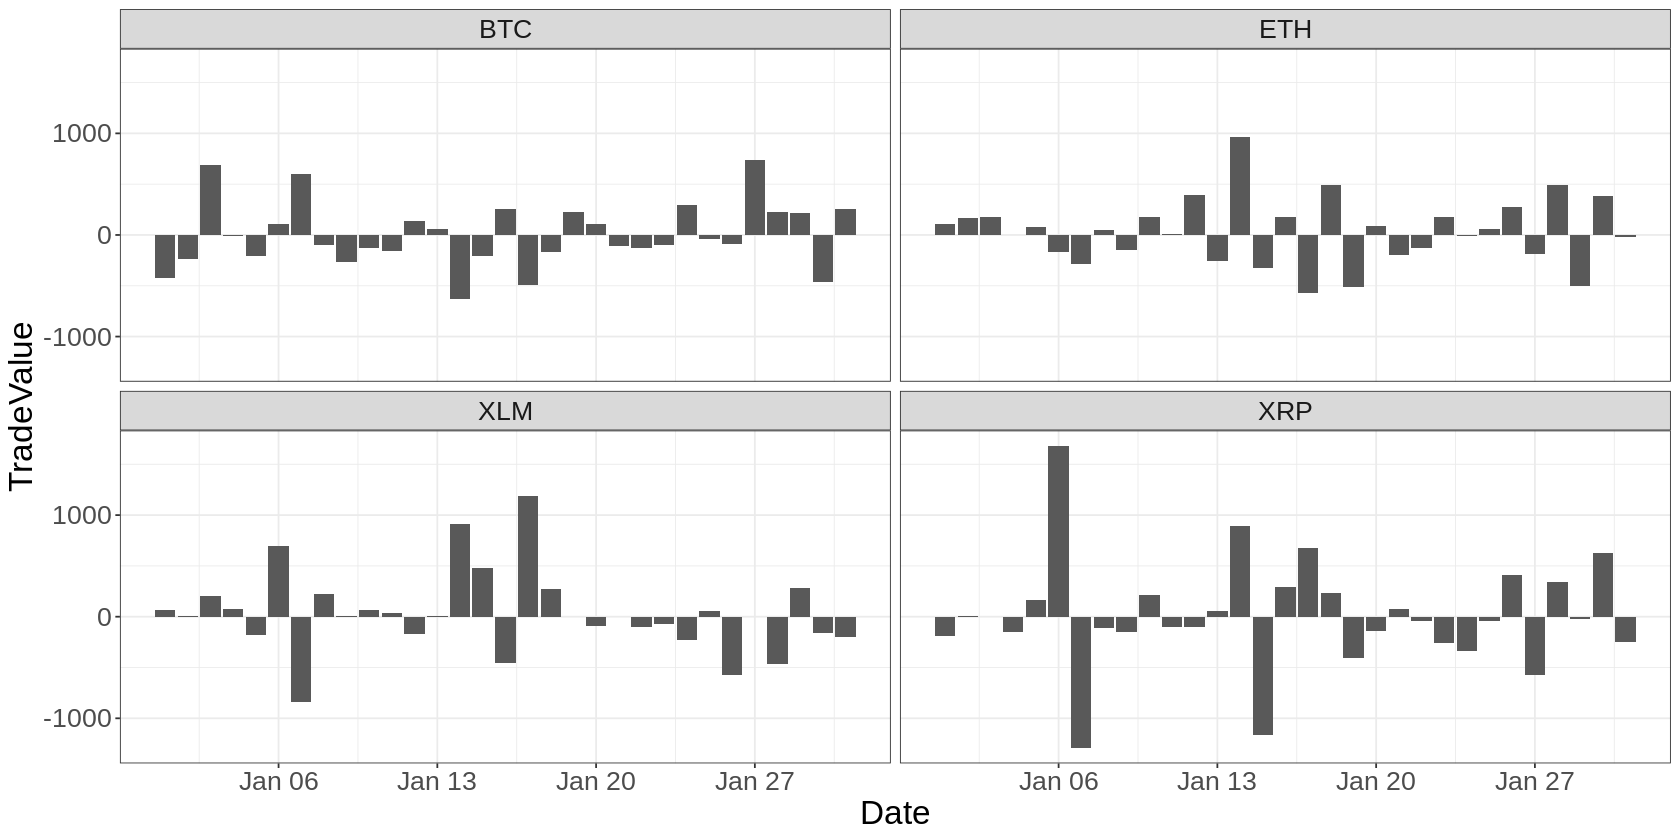

In [94]:
results_df <- cash_backtest(
  backtest_prices, 
  backtest_weights, 
  trade_buffer = 0., 
  initial_cash, 
  commission_pct, 
  capitalise_profits
)

results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"), 
    Date >= "2020-01-01", 
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)